# Applying a Model to light curves

This notebook will go through reformatting an Otter JSON file to the JSON file format expected by MOSFiT (https://mosfit.readthedocs.io/en/latest/)

First, go to that link above and install mosfit if you haven't already!

### Setup

In [1]:
# imports
import otter
import mosfit
import numpy as np
import pandas as pd
import os
import glob
import json
from collections import OrderedDict

import matplotlib.pyplot as plt

from astropy import units as u

In [ ]:
# connect to the dataset
db = otter.Otter()

In [4]:
# Select the mosfit TDE model since we will later be modeling a TDE
model = mosfit.model.Model(model='tde')

### Converting the OTTER dataset to MOSFiT format

The below function will do this conversion for us!

In [5]:
def otter_to_mosfit(db, names, outdir="", verbose=True, **query_kwargs):

    outpaths = []
    for name in names:
        phot = db.get_phot(obs_type="uvoir", names=name, flux_unit="mJy", **query_kwargs)
    
        meta = db.get_meta(names=name)[0]
        
        col_map = {
            "filter_name" : "band",
            "converted_flux" : "f_nu",
            "converted_flux_err" : "e_flux_density",
            "converted_flux_units": "u_flux",
            "converted_date" : "time"
        }
        phot = phot.rename(columns=col_map)
    
        phot = phot.drop(columns = [
            "converted_freq",
            "converted_flux_unit",
            "converted_date_unit",
            "converted_freq_unit",
            "obs_type",
            "human_readable_refs"
        ])
    
        
        phot.time = phot.time.astype(float)
        phot["instrument"] = None
        phot["redshift"] = meta.get_redshift()
        phot["name"] = name

        phot["band"] = [b.split(".")[0].strip() for b in phot.band]

        # only take data from 50 days before to 1 year after discovery
        discovery = meta.get_discovery_date().mjd
        phot = phot[(phot.time > discovery-50) * (phot.time < discovery+365)]
        if not len(phot):
            if not verbose: continue
            print(f"Skipping {name} because no good photometry!")
            continue

        # handle upperlimits
        # this includes binning the data if needed 
        phot.upperlimit = phot.apply(lambda row : row.f_nu < 3*row.e_flux_density if pd.isna(row.upperlimit) else row.upperlimit, axis=1)

        # convert it to the astrocat json format
        outpath = os.path.join(outdir, f"{name}.csv")
        phot.to_csv(outpath, index=False, sep='\t')
        outpaths.append(outpath)
              

        if not verbose: continue
        fig, ax = plt.subplots()
        ax.set_ylabel("Flux [mJy]")
        ax.set_xlabel("MJD")
        ax.set_title(f"Fitting Data for {name}")
        for band, grp in phot.groupby('band'):
            uplims = grp[grp.upperlimit]
            dets = grp[~grp.upperlimit]
    
            ax.errorbar(dets.time, dets.f_nu, yerr=dets.e_flux_density, marker='o', linestyle='none', color=mosfit.plotting.bandcolorf(band), label=band)
            ax.plot(uplims.time, uplims.f_nu, marker='v', linestyle='none', color=mosfit.plotting.bandcolorf(band))


    printer = mosfit.printer.Printer()
    converter = mosfit.converter.Converter(printer)    
    outjsons = converter.generate_event_list(outpaths)

    for j in outjsons:
        os.rename(j, os.path.join(outdir, j))
        
    return outjsons

Now we can call this function to convert the otter datafile of AT2021sdu to the mosfit format


The ASCII converter in MOSFiT converts flat ASCII tables to the Open Catalog's JSON schema. Inputs
are preferably provided by the user in the fixed-width CDS format, but if not, the converter works
best if the data:
1. Uses consistent delimeters throughout (i.e. just tabs, just spaces, etc.).
2. Has a single header column specifying column contents.
3. Specifies the instrument and photometric system used for each observation.
4. Contains a single event per file (not multiple events per file or multiple files per event).

Please note that conversions are inherently imperfect and that you should always scan the output
JSON file for errors.

Converting input file `./AT2021sdu.csv` to JSON format...


Could not automatically find a column corresponding to `telescope`, which of the following columns
correponds to this quantity?
  1.  nm, nm, nm, nm, nm, ...
 [n.] No column correponds to this quantity.


Enter selection (1/[n]):  n


Please specify `telescope`, which will be assumed for all rows (leave blank if not known):  


What are the units of the flux density column, e.g. "µJy" or "millijansky" (if left blank, "µJy"
will be assumed):  millijansky


['AT2021sdu.json']

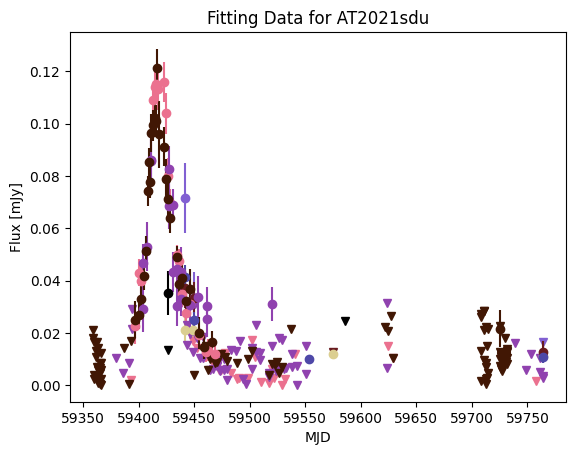

In [7]:
query_kwargs = dict(
    return_type = "pandas"
)

phot_files = otter_to_mosfit(db, names = ["AT2021sdu"], outdir=".", **query_kwargs)
phot_files

And you should now be able to run MOSFiT like you normally would from the terminal on this file!